In [1]:
import numpy as np
import torch
import torch.nn as nn

import copy
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import gym

### Problem

Let's get some information about environment

In [2]:
env = gym.make("MountainCar-v0")

In [3]:
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Discrete(3)
Box(2,)
[0.6  0.07]
[-1.2  -0.07]


In [4]:
total_rewards = []
episode_max = 1000

for episode in range(episode_max):
    state = env.reset()
    episode_reward = 0
    
    done = False
    while not done:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        
        if done:
            total_rewards.append(episode_reward)
            break
env.close()

In [5]:
np.unique(total_rewards)

array([-200.])

In [6]:
total_rewards = np.array(total_rewards)
print(f"Task was solved {len(total_rewards[total_rewards > -200])} times out of {episode_max} with random action algorithm.")

Task was solved 0 times out of 1000 with random action algorithm.


It's clear that provided task can't be solved with simple policy of taking random actions. Let's try to learn optimal policy with deep Q learning algorithm. More precisely, we will learn Q values and than take based on them choose next action.

### Model

Let's first define DL model

In [7]:
observation_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
hidden_dim = 32

In [8]:
def create_model(hidden_dim=hidden_dim):
    return nn.Sequential(
        nn.Linear(observation_space_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, action_space_dim)
    )

In [9]:
def init_weights_default(layer):
    pass

In [10]:
def init_weights_xavier(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [11]:
model = create_model()
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=3, bias=True)
)


In deep learning, the target labels are not changing over training. That makes training stable. Since in Q learning estimation of Q-values is based on another Q-values we are dealing with continiously changing target. To make RL model more stable we will use two models. One will be fixed till another one is training. Once in a while we will update first model too. Information is took from [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/).

In [12]:
fixed_model = copy.deepcopy(model)

### Experience Replay

Also we will use Experience replay technique. Good motivation and explonation of it is provided in [Dealing with Sparse Rewards in Reinforcement Learning](https://arxiv.org/abs/1910.09281):

If using a gradient based iterative optimisation process as done via back-propagation in
neural networks, it is important that the data is independent and identically distributed (i.i.d.).
This is done as to avoid sampling bias from correlated inputs, which can cause the gradient to get
stuck in a non-optimal local maxima (as we are performing gradient ascent to maximise the expected
future reward). Experience replay is a method to help decorrelate the sequential experiences gained
from dynamic programming and model free reinforcement learning methods. This is done by storing
experiences, a tuple of (st, at, rt, st+1) into a list of experiences known as the replay memory. Batch
samples can be drawn randomly from the replay memory which provide ∼ i.i.d. for a large replay
length.

In [13]:
class Experience:
    """Class for implementing Experience Replay technique"""
    def __init__(self, capacity, weighted=False):
        self.capacity = capacity
        self.experience = []
        self.weighted = weighted

    def add(self, el):
        self.experience.append(el)
        self.experience = self.experience[-self.capacity:]

    def sample(self, batch_size):
        if self.weighted:
            raise NotImplementedError
        else:
            return random.sample(self.experience, batch_size)

There is one possible improvement in base Experience Replay method regarding the way of sampling. We can use weighted sampling to put more attention to states with greater reward.

### Fitting network

To fit network we have to calculate predicted by model Q-values and target Q-values created by fixed model.

In [14]:
def fit(model, fixed_model, data, optimizer, criterion, gamma=0.99):
    """Trains model with data from batch"""
    state, action, reward, next_state, done = list(zip(*data))
    
    state = torch.tensor(state).float()
    action = torch.tensor(action)
    reward = torch.tensor(reward).float()
    next_state = torch.tensor(next_state).float()
    done = torch.tensor(done).int()

    with torch.no_grad():
        target = reward + gamma * torch.max(fixed_model(next_state)) * done
    target = target.unsqueeze(1)
    
    predicted = model(state).gather(1, action.unsqueeze(1))
    
    loss = criterion(predicted, target)
    
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Reward function

Let's first define base reward function:

In [15]:
def calc_base_reward(state, reward, next_state):
    return reward

Major difficulty of Mountain car task is extremely sparce rewards: reward is -1 after each step till goal is not reached. To make reward function more dense and therefore make it easier for agent to learn we will add some heuristic to it. There is a paper about how to do that correctly: [Policy invarience under reward transformation. Theory and application of reward shaping](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf).

#### Kinetic

It's logical that car need high speed to reach goal. Thus, let's give reward according to car's speed.

In [16]:
def calc_reward_kinetic(state, reward, next_state):
    return reward + 10 * abs(next_state[1])

In [17]:
def calc_reward_kinetic_v2(state, reward, next_state):
    return reward + 300 * (0.9 * abs(next_state[1]) - abs(state[1]))

#### Potential

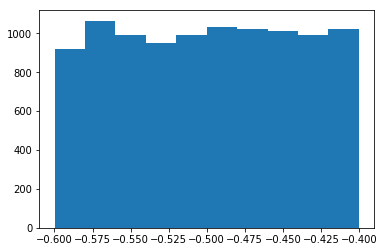

In [18]:
initial_positions = []
for _ in range(10000):
    state = env.reset()
    initial_positions.append(state[0])

plt.hist(initial_positions)
plt.show()

We can see that start positions are uniformly distributed over segment [-0.6, -0.4]. Also we know that mountains are from both side of initial position. To reach goal car have to clumb high into the mountains. Thus, let's give additional reward according to car's height in the mountains. In current task it is equalent to distance from initial position: the more is distance the more is height. Beside major goal this reward will in some kind encorage exploration of space.

In [19]:
initial_position = np.mean(initial_positions)
initial_position

-0.49914412747500647

In [36]:
def potential(x):
    return abs(x - initial_position) 

In [21]:
def calc_reward_potential(state, reward, next_state):
    return reward + 10 * potential(next_state[0])

In [22]:
def calc_reward_potential_v2(state, reward, next_state):
    return reward + 300 * (0.99 * potential(next_state[0]) - potential(state[0]))

We also can combine both ideas (Kinetic and Potential rewards)

In [23]:
def calc_reward_combined(state, reward, next_state):
    return reward + 5 * abs(next_state[1]) + 5 * potential(next_state[0])

In [24]:
def calc_reward_combined_v2(state, reward, next_state):
    return reward + 150 * (0.9 * abs(next_state[1]) - abs(state[1])) \
            + 150 * (0.99 * potential(next_state[0]) - potential(state[0]))

### Training

For training we will use eps-greedy policy with decreasing eps over time.

In [25]:
def greedy_action(model, state, eps=0):
    """Returns action in accordance with eps-greedy policy"""
#     with torch.no_grad():
    if np.random.rand() <= eps:
        return np.random.choice(action_space_dim)
    else:
        output = model(torch.tensor(state).float())
        return torch.argmax(output).item()

In [26]:
def validate_model(model, draw=False):
    """Simulate model in environment"""
    state = env.reset()
    total_reward = 0
    done=False
    while not done:
        if draw:
            env.render()
        action = greedy_action(model, state)
        state, reward, done, _ = env.step(action)
        total_reward += reward

    state = env.reset()  
    if draw:
        env.close()
    return total_reward

In [27]:
def train(criterion, reward_function, learning_rate, init_weights_func=init_weights_default,
          time_max=100000, batchsize=128, fixed_model_update=1000,
          eps_min=0.1, eps_max=0.5):
    total_rewards = []
    
    model = create_model()
    fixed_model = copy.deepcopy(model)
    model.apply(init_weights_func)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    experience = Experience(capacity=5000)
    
    state = env.reset()
    
    for time in tqdm(range(time_max)):
        eps = eps_max - (eps_max - eps_min) * time / time_max
        action = greedy_action(model, state, eps)
        next_state, reward, done, _ = env.step(action)
        
        experience.add([
            state,
            action,
            reward_function(state, reward, next_state),
            next_state,
            done
        ])
        
        if time > batchsize:
            fit(model, fixed_model, experience.sample(batchsize), optimizer, criterion) # Train model
                
        if time % fixed_model_update == 0:
            fixed_model = copy.deepcopy(model)
            total_rewards.append(validate_model(fixed_model))
            
        if done: # Restart simulation
            state = env.reset()
        else:
            state = next_state
    return model, total_rewards

### Experiments

Let's test different setups of training options. We will compare:
* 2 loss functions
* 3 learning rates
* 2 initializations of model's weights

In [28]:
time_max = 50000
criterions = [nn.functional.mse_loss, nn.functional.smooth_l1_loss]
lrs = [0.01, 0.001, 0.0001]
reward_function = calc_reward_kinetic_v2
init_weights_functions = [init_weights_default, init_weights_xavier]

configs = []
results = []

for criterion in criterions:
    for lr in lrs:
        for init_weights_function in init_weights_functions:
            config = criterion.__name__ + " " + str(lr) + " " + init_weights_function.__name__
            model, total_reward = train(criterion,
                                        reward_function,
                                        lr,
                                        init_weights_function,
                                        time_max=time_max,
                                        batchsize=128)

            print(f"Training configuration: {config}, mean total reward: {np.mean(total_reward)}")
            configs.append(config)
            results.append(total_reward)



Training configuration: mse_loss 0.01 init_weights_default, mean total reward: -123.24



Training configuration: mse_loss 0.01 init_weights_xavier, mean total reward: -119.28



Training configuration: mse_loss 0.001 init_weights_default, mean total reward: -127.2



Training configuration: mse_loss 0.001 init_weights_xavier, mean total reward: -129.38



Training configuration: mse_loss 0.0001 init_weights_default, mean total reward: -150.72



Training configuration: mse_loss 0.0001 init_weights_xavier, mean total reward: -152.76



Training configuration: smooth_l1_loss 0.01 init_weights_default, mean total reward: -119.72



Training configuration: smooth_l1_loss 0.01 init_weights_xavier, mean total reward: -121.5



Training configuration: smooth_l1_loss 0.001 init_weights_default, mean total reward: -113.02



Training configuration: smooth_l1_loss 0.001 init_weights_xavier, mean total reward: -131.2



Training configuration: smooth_l1_loss 0.0001 init_weights_default, mean total reward: -171.22



Training configuration: smooth_l1_loss 0.0001 init_weights_xavier, mean total reward: -156.62


### Results analysis

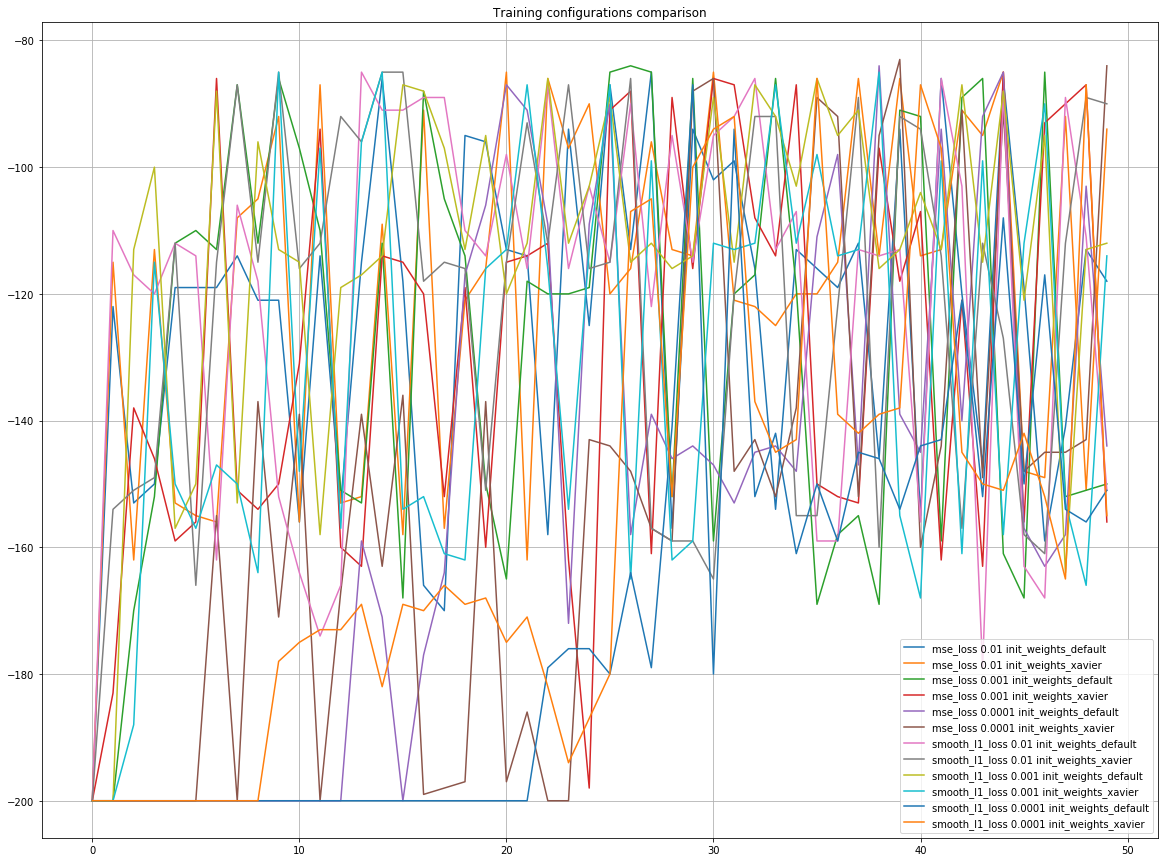

In [29]:
plt.figure(figsize=(20, 15))
plt.title("Training configurations comparison")
for i in range(len(results)):
    plt.plot(range(len(results[i])), results[i], label=configs[i])
plt.legend()
plt.grid()
plt.show()

What we can see from this messy plot is that model managed to reach the goal with each configuration. 

#### Weigth initialisation

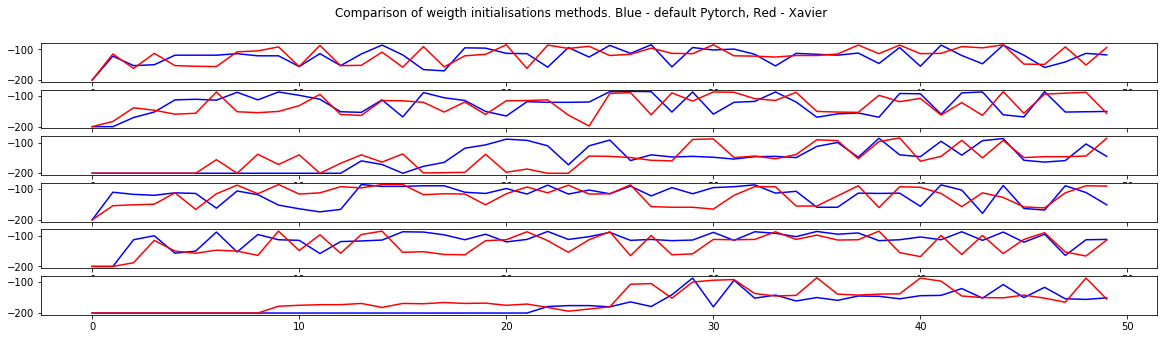

In [30]:
default_indices = [i for i in range(len(results)) if "default" in configs[i]]
xavier_indices = [i for i in range(len(results)) if "xavier" in configs[i]]
plots_n = len(default_indices)

fig, axs = plt.subplots(plots_n, figsize=(20, 5))
fig.suptitle("Comparison of weigth initialisations methods. Blue - default Pytorch, Red - Xavier")
for i, (default_ind, xavier_ind) in enumerate(zip(default_indices, xavier_indices)):
    axs[i].plot(range(len(results[default_ind])), results[default_ind], color="blue")
    axs[i].plot(range(len(results[xavier_ind])), results[xavier_ind], color="red")
plt.show()

As we can see there is no obvious correlation between initialisation of weights and model's perfomance.

#### Loss functions

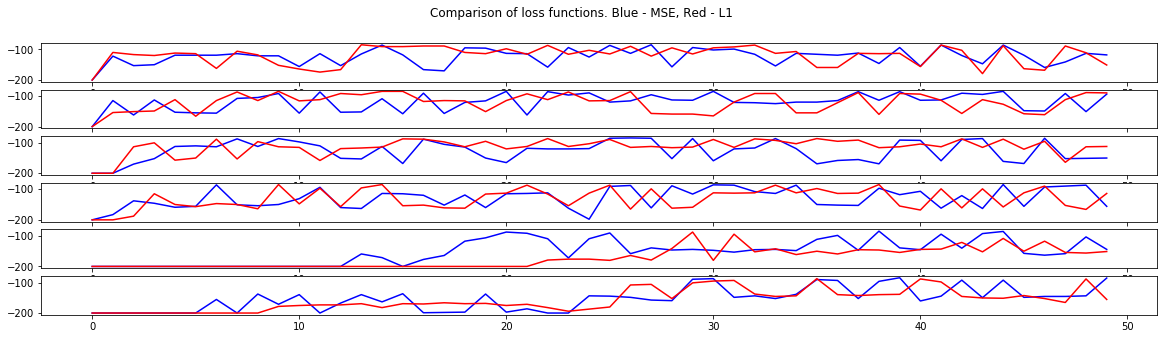

In [31]:
mse_indices = [i for i in range(len(results)) if "mse" in configs[i]]
l1_indices = [i for i in range(len(results)) if "l1" in configs[i]]
plots_n = len(mse_indices)

fig, axs = plt.subplots(plots_n, figsize=(20, 5))
fig.suptitle("Comparison of loss functions. Blue - MSE, Red - L1")
for i, (mse_ind, l1_ind) in enumerate(zip(mse_indices, l1_indices)):
    axs[i].plot(range(len(results[mse_ind])), results[mse_ind], color="blue")
    axs[i].plot(range(len(results[l1_ind])), results[l1_ind], color="red")
plt.show()

As we can see there is no obvious correlation between loss function and model's perfomance.

### Learning rate

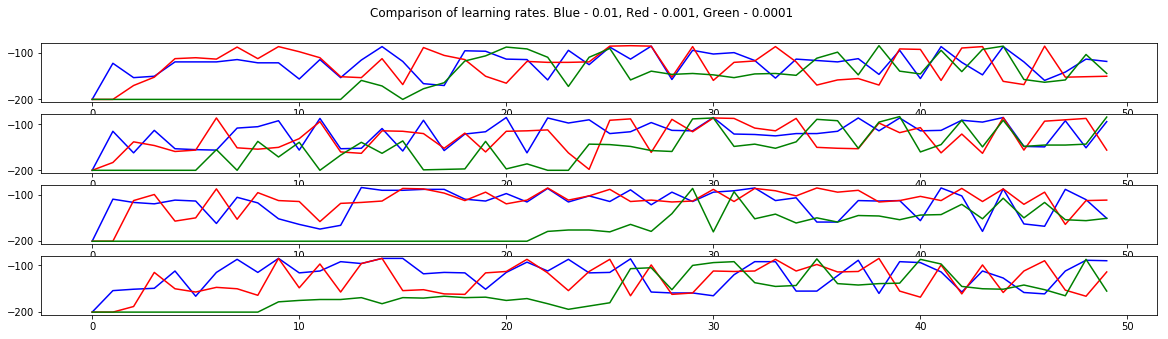

In [32]:
lr1_indices = [i for i in range(len(results)) if str(lrs[0]) in configs[i]]
lr2_indices = [i for i in range(len(results)) if str(lrs[1]) in configs[i]]
lr3_indices = [i for i in range(len(results)) if str(lrs[2]) in configs[i]]
plots_n = len(lr1_indices)

fig, axs = plt.subplots(plots_n, figsize=(20, 5))
fig.suptitle(f"Comparison of learning rates. Blue - {str(lrs[0])}, Red - {str(lrs[1])}, Green - {str(lrs[2])}")
for i, (lr1_ind, lr2_ind, lr3_ind) in enumerate(zip(lr1_indices, lr2_indices, lr3_indices)):
    axs[i].plot(range(len(results[lr1_ind])), results[lr1_ind], color="blue")
    axs[i].plot(range(len(results[lr2_ind])), results[lr2_ind], color="red")
    axs[i].plot(range(len(results[lr3_ind])), results[lr3_ind], color="green")
plt.show()

Plot reveals obvious fact that learning rate unfluences models perfomance. Among tested values 1e-2 and 1e-3 are best ones.

In [ ]:
for lr1_ind, lr2_ind in zip(lr1_indices, lr2_indices):
    print(f"Learning rate: {str(lrs[0])} vs {str(lrs[1])} mean total reward: {np.mean(results[lr1_ind])} vs {np.mean(results[lr2_ind])}")

#### Reward function

Now let's compare proposed reward functions (7 in total).

In [38]:
time_max = 50000
criterion = nn.functional.mse_loss
lr = 0.01
reward_functions = [calc_base_reward,
                    calc_reward_kinetic,
                    calc_reward_kinetic_v2,
                    calc_reward_potential,
                    calc_reward_potential_v2,
                    calc_reward_combined,
                    calc_reward_combined_v2]
init_weights_function = init_weights_default

configs = []
results = []


for reward_function in reward_functions:
    config = reward_function.__name__
    model, total_reward = train(criterion,
                                reward_function,
                                lr,
                                init_weights_function,
                                time_max=time_max,
                                batchsize=128)

    print(f"Training configuration: {config}, mean total reward: {np.mean(total_reward)}")
    configs.append(config)
    results.append(total_reward)


Training configuration: calc_base_reward, mean total reward: -200.0


Training configuration: calc_reward_kinetic, mean total reward: -148.16


Training configuration: calc_reward_kinetic_v2, mean total reward: -115.72


Training configuration: calc_reward_potential, mean total reward: -200.0


Training configuration: calc_reward_potential_v2, mean total reward: -200.0


Training configuration: calc_reward_combined, mean total reward: -198.76


Training configuration: calc_reward_combined_v2, mean total reward: -193.76


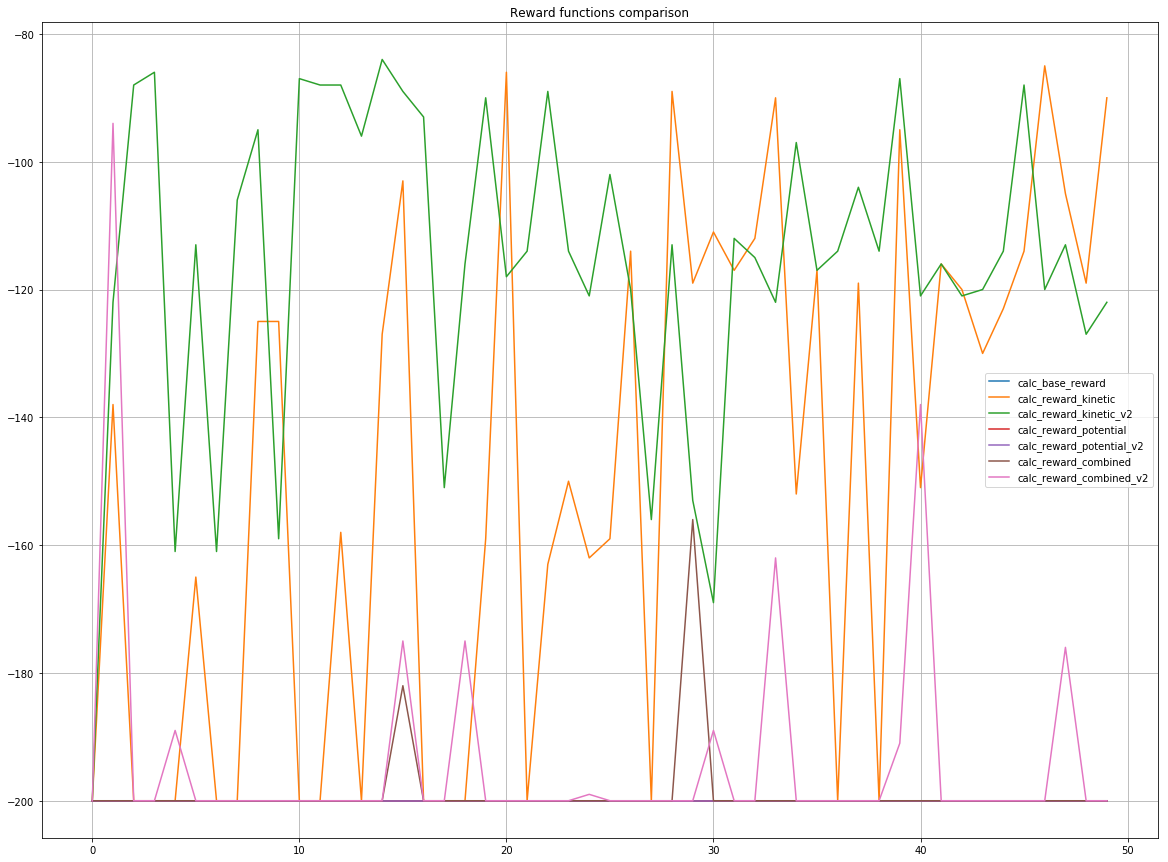

In [39]:
plt.figure(figsize=(20, 15))
plt.title("Reward functions comparison")
for i in range(len(results)):
    plt.plot(range(len(results[i])), results[i], label=configs[i])
plt.legend()
plt.grid()
plt.show()

We can conclude that:
* Default Pytorch and Xavier weights initialisation show the same perfomance
* MSE and L1 loss functions show the same perfomance
* 0.001 is the best learning rate in current setup among teste ones
* 

In [ ]:
# # Train best model
# best_model, _ = train(nn.functional.mse_loss,
#                       calc_reward_kinetic,
#                       0.001,
#                       init_weights_default,
#                       time_max=100000,
#                       batchsize=128)

### Test

In [ ]:
# total_reward = validate_model(best_model, draw=True)
# print(f"Reward: {total_reward}")